# Step-By-Step Implementation of DynamicUnet

In [1]:
from fastai2.vision.all import *

## Data

In [2]:
path = untar_data(URLs.CAMVID)
Path.BASE_PATH = path
path.ls()

(#5) [Path('codes.txt'),Path('images'),Path('valid.txt'),Path('models'),Path('labels')]

In [3]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [4]:
valid_files = (path/'valid.txt').read().split('\n')

In [5]:
def list_splitter(valid_files):
    def _inner(files):
        val_mask = tensor([file.name in valid_files for file in files])
        return [~val_mask, val_mask]
    return _inner

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_image_files,
    splitter=list_splitter(valid_files),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=[*aug_transforms(size=(360, 480)), 
                Normalize.from_stats(*imagenet_stats)])

In [7]:
dls = dblock.dataloaders(path/'images', bs=16)
dls.vocab = codes

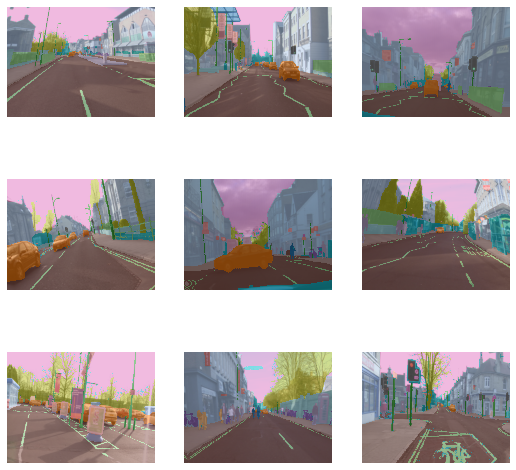

In [8]:
dls.show_batch()

## Step 1: Create Pretrained encoder and cut off the head
---
For the encoder, we don't need the head of the pretrained model which is used for classification purposes. We only need the convolutional part.

In [9]:
encoder = resnet34(pretrained=True)

In [10]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

The cut property tells us the index at which to cut off the head.

In [11]:
cut = model_meta[resnet34].get('cut')
cut

-2

In [12]:
encoder = nn.Sequential(*list(encoder.children())[:cut])
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

The same functionality can be achieved with the `create_body` function in fastai2

In [13]:
encoder = create_body(resnet34, pretrained=True)

Step 2: Get the output shape of each module in the encoder-
---


## Step 2: Perform a single pass through the encoder to get the indexes of the layers immediately before the layers that change the size of the input image.
---
We want to find the layers that are before either a max pooling or stride 2 covolution resulting in the reduction in the size of the input. The output of these layers will be used for the skip connections. For eg. in the original unet architecture below there are skip connections before each max pooling layer. 

We do this by passing a dummy input through the model and using hooks to record the shape of the output of each module. Knowing the ouput of each module would help us to determine the layers on which to place the cross connections.

![Unet Architecture](u-net-architecture.png)

In [14]:
class Hook:
    def __init__(self, m, detach=True):
        self.detach = detach
        self.hook = m.register_forward_hook(self.hook_func)
    
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone() if self.detach else o
        
    def remove   (self): self.hook.remove()    
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()

In [15]:
class Hooks:
    def __init__(self, ms, detach=True):
        self.hooks = [Hook(m, detach) for m in ms]
    def remove(self):
        for hk in self.hooks: hk.remove()
    def __len__    (self):    return len(self.hooks)
    def __getitem__(self, i): return self.hooks[i]
    def __iter__   (self):    return iter(self.hooks)
    def __enter__  (self, *args): return self
    def __exit__   (self, *args): self.remove()

Create a dummy input

In [16]:
imsize = dls.one_batch()[0].shape[-2:]
imsize

torch.Size([360, 480])

In [17]:
inp = torch.randn(1, 3, *imsize)

Attach hooks to the encoder and get the sizes of the outputs

In [18]:
with Hooks(encoder) as size_hooks:
    _ = encoder.eval()(inp)
    sizes = [hook.stored.shape for hook in size_hooks]

In [19]:
sizes

[torch.Size([1, 64, 180, 240]),
 torch.Size([1, 64, 180, 240]),
 torch.Size([1, 64, 180, 240]),
 torch.Size([1, 64, 90, 120]),
 torch.Size([1, 64, 90, 120]),
 torch.Size([1, 128, 45, 60]),
 torch.Size([1, 256, 23, 30]),
 torch.Size([1, 512, 12, 15])]

get the indexes of the layers immediately before the layers where the size changes

In [20]:
widths = [size[-1] for size in sizes]
widths

[240, 240, 240, 120, 120, 60, 30, 15]

In [21]:
sz_chg_idxs = list(np.where(np.array(widths[:-1]) != np.array(widths[1:]))[0])
sz_chg_idxs

[2, 4, 5, 6]

create a function for step 2

In [22]:
def get_skip_idxs(encoder, inp):
    with Hooks(encoder) as size_hooks:
        _ = encoder.eval()(inp)
        sizes = [hook.stored.shape for hook in size_hooks]
    widths = [size[-1] for size in sizes]
    sz_chg_idxs = list(np.where(np.array(widths[:-1]) != np.array(widths[1:]))[0])
    return sizes, sz_chg_idxs

## Step 3: Attach hooks to the encoder at the indexes found in step 2 for use in the upsampling path
---
We need these hooks to store the outputs of those layers for use later in the upsampling path. The outputs of those layers would be concatenated with the results of the upsampling.

In [23]:
sizes, sz_chg_idxs = get_skip_idxs(encoder, inp)
sz_chg_idxs

[2, 4, 5, 6]

In [24]:
sz_chg_idxs = list(reversed(sz_chg_idxs))
sz_chg_idxs

[6, 5, 4, 2]

In [25]:
up_hooks = Hooks([encoder[idx] for idx in sz_chg_idxs])

## Step 4: Attach middle layers to encoder
---
The encoder forms the downsampling path (the red circle in the image below, whiles the decoder is the green circle. We need to define the layers circled in blue and attach them to the encoder.

![blocks in unet](u-net-architecture-mid.jpg)

In [26]:
nf = sizes[-1][1] # number of features in output of encoder

In [27]:
midle_conv = nn.Sequential(ConvLayer(nf, nf//2, norm_type=None),
                           ConvLayer(nf//2, nf, norm_type=None))

## Step 5: Create Decoder and append to encoder and middle conv
---
At step of the decoder, we need to know the number of feature maps in the output of the last layer in other to rightly define the next layer. We need to perform a single pass through each new block to be able to keep track of the number of feature maps.

In [28]:
class DecoderBlock(Module):
    def __init__(self, up_channels, hook_channels, hook, final_div=True):
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_channels, up_channels//2)
        self.bn = BatchNorm(hook_channels)
        
        ni = up_channels//2 + hook_channels
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, norm_type=None)
        self.conv2 = ConvLayer(nf, nf, norm_type=None)
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        hook_output = self.hook.stored
        sz = hook_output.shape[-2:]
        upsample = self.shuf(x)
        
        if sz != upsample.shape[-2:]:
            upsample = F.interpolate(upsample, size=sz, mode='nearest')
            
        res = self.act(torch.cat((upsample, self.bn(hook_output)), dim=1))
        return self.conv2(self.conv1(res))

Combine steps 2 to 4 together with step 5 into one class

In [29]:
class DynaUnet(SequentialEx):
    def __init__(self, encoder, imsize, n_classes, last_cross=True):
        # create dummy input 
        x = torch.randn(1, 3, *imsize)
        # step 2
        sizes, sz_chg_idxs = get_skip_idxs(encoder, x)
        sz_chg_idxs = list(reversed(sz_chg_idxs))
        # step 3 
        up_hooks = Hooks([encoder[idx] for idx in sz_chg_idxs])
        
        x = encoder.eval()(x)
        nf = sizes[-1][1]
        # step 4
        middle_conv = nn.Sequential(ConvLayer(nf, nf//2, norm_type=None),
                           ConvLayer(nf//2, nf, norm_type=None)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(nf), nn.ReLU(), middle_conv]
        
        for i, idx in enumerate(sz_chg_idxs):
            not_final = i != len(sz_chg_idxs) - 1
            up_channels = x.shape[1]
            hook_channels = sizes[idx][1]
            block = DecoderBlock(up_channels, hook_channels, up_hooks[i], not_final)
            layers.append(block)
            x = block(x)
        
        nf = x.shape[1]
        if x.shape[-2:] != imsize:
            layers.append(PixelShuffle_ICNR(nf))
        
        if last_cross:
            layers.append(MergeLayer(dense=True))
            nf += 3
            layers.append(ResBlock(1, nf, nf))
        
        layers.append(ConvLayer(nf, n_classes, ks=1, norm_type=None, act_cls=None))
        
        super().__init__(*layers)
    
    def __del__(self):
        self.up_hooks.remove()

In [30]:
def my_unet_learner(dls, arch, metrics):
    encoder = create_body(arch)
    imsize = dls.one_batch()[0].shape[-2:]
    n_classes = get_c(dls)
    
    model = DynaUnet(encoder, imsize, n_classes)
    return Learner(dls, model, metrics=metrics)

define metric for camvid

In [31]:
val2idx = L([code for code in codes]).val2idx()
void_code = val2idx['Void']
void_code

30

In [32]:
def acc_camvid(pred, targ):
    mask = targ != void_code
    return (pred.argmax(dim=1)[mask] == targ[mask]).float().mean()

compare to original implementation

In [33]:
orig_unet = unet_learner(dls, resnet34, metrics=acc_camvid)

In [34]:
orig_unet.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [35]:
my_unet = my_unet_learner(dls, resnet34, acc_camvid)

In [36]:
my_unet.model

DynaUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, m